## В рамках этой ЛР будем использовать другой датасет - собаки против змей. Посмотрим размер картинок

In [1]:
from PIL import Image

image = Image.open("labs_data/lab1_2_6/1. Satellite - cloudy vs desert/cloudy/train_12.jpg")
print(image.width, image.height)

256 256


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.metrics import accuracy_score
import os
from PIL import Image

from src.logger import logger
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "labs_data/lab1_2_6/2. Animals - dogs vs snakes"


/home/i.danilov/sandbox/nn_labs/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-11 09:31:50.622867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/i.danilov/sandbox/nn_labs/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### Сделаем трансформации и создадим датасеты для CNN. Данные будут раздеделены train:val:test как 0.6:0.2:0.2
#### Применим аугментацию для обучащего набора - случайные повороты, отражения, разные варианты яркости, контрастности и т.д.


In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 16

train_transform_cnn = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

val_test_transform_cnn = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=None) 

logger.info(f"Общее количество изображений: {len(full_dataset)}")
logger.info(f"Классы: {full_dataset.classes}")
class_to_idx = full_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
logger.info(f"Класс -> Индекс: {class_to_idx}")

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

logger.info(f"Размеры наборов: Train={train_size}, Val={val_size}, Test={test_size}")

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)

class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset_cnn = TransformedDataset(train_dataset, transform=train_transform_cnn)
val_dataset_cnn = TransformedDataset(val_dataset, transform=val_test_transform_cnn)
test_dataset_cnn = TransformedDataset(test_dataset, transform=val_test_transform_cnn)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

logger.info("Даталоадеры для CNN созданы.")

2026-01-11 09:31:53,073 - src.logger - 22 - INFO - Общее количество изображений: 2000
2026-01-11 09:31:53,074 - src.logger - 23 - INFO - Классы: ['dogs', 'snakes']
2026-01-11 09:31:53,074 - src.logger - 26 - INFO - Класс -> Индекс: {'dogs': 0, 'snakes': 1}
2026-01-11 09:31:53,075 - src.logger - 37 - INFO - Размеры наборов: Train=1200, Val=400, Test=400
2026-01-11 09:31:53,076 - src.logger - 64 - INFO - Даталоадеры для CNN созданы.


### Создаим модель на базе resnet50 из torchvision, заморозим веса у предобученной части, а к последнему слою добавим Dropout и BatchNorm 

In [ ]:
class CNNDogSnakeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNDogSnakeClassifier, self).__init__()
        self.backbone = models.resnet50(weights=True)
        
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        num_features = self.backbone.fc.in_features

        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

model_cnn = CNNDogSnakeClassifier(num_classes=len(class_to_idx)).to(device)

criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=2e-5)
scheduler_cnn = optim.lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

logger.info(model_cnn)

/home/i.danilov/sandbox/nn_labs/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2026-01-11 09:31:53,487 - src.logger - 32 - INFO - CNNDogSnakeClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mom

### Обучим CNN модель на 10 эпохах, также с методом ранней остановки.

In [ ]:
NUM_EPOCHS_CNN = 10 
best_val_acc_cnn = 0.0
patience = 3
epochs_without_improvement = 3

logger.info("Начинается обучение CNN...")
for epoch in range(NUM_EPOCHS_CNN):
    logger.info(f"\nEpoch {epoch+1}/{NUM_EPOCHS_CNN}")
    
    model_cnn.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (data, targets) in enumerate(train_loader_cnn):
        data, targets = data.to(device), targets.to(device)

        optimizer_cnn.zero_grad()
        outputs = model_cnn(data)
        loss = criterion_cnn(outputs, targets)
        loss.backward()
        optimizer_cnn.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

        if batch_idx % 50 == 0: 
            logger.info(f'  Batch {batch_idx}, Loss: {loss.item():.4f}')

    epoch_train_loss = running_loss / len(train_loader_cnn)
    epoch_train_acc = correct_predictions / total_samples
    logger.info(f'  Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}')

    model_cnn.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for data, targets in val_loader_cnn:
            data, targets = data.to(device), targets.to(device)
            outputs = model_cnn(data)
            loss = criterion_cnn(outputs, targets)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total_samples += targets.size(0)
            val_correct_predictions += (predicted == targets).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader_cnn)
    epoch_val_acc = val_correct_predictions / val_total_samples
    logger.info(f'  Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}')
    
    scheduler_cnn.step() 
    
    if epoch_val_acc > best_val_acc_cnn:
        logger.info(f"  Новая лучшая модель на эпохе {epoch+1}. Сохранение...")
        best_val_acc_cnn = epoch_val_acc
        torch.save(model_cnn.state_dict(), 'best_model_cnn.pth')
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        
    if epochs_without_improvement >= patience:
        logger.info(f"  Ранняя остановка на эпохе {epoch+1}")
        break

logger.info("\nОбучение CNN завершено.")
model_cnn.load_state_dict(torch.load('best_model_cnn.pth'))

2026-01-11 09:31:53,498 - src.logger - 7 - INFO - Начинается обучение CNN...
2026-01-11 09:31:53,499 - src.logger - 9 - INFO - 
Epoch 1/10
2026-01-11 09:31:53,949 - src.logger - 31 - INFO -   Batch 0, Loss: 0.6957
2026-01-11 09:31:55,857 - src.logger - 31 - INFO -   Batch 50, Loss: 0.2899
2026-01-11 09:31:56,880 - src.logger - 35 - INFO -   Train Loss: 0.4282, Acc: 0.8408
2026-01-11 09:31:57,612 - src.logger - 55 - INFO -   Val Loss: 0.1974, Acc: 0.9900
2026-01-11 09:31:57,613 - src.logger - 60 - INFO -   Новая лучшая модель на эпохе 1. Сохранение...
2026-01-11 09:31:58,075 - src.logger - 9 - INFO - 
Epoch 2/10
2026-01-11 09:31:58,289 - src.logger - 31 - INFO -   Batch 0, Loss: 0.2381
2026-01-11 09:32:00,199 - src.logger - 31 - INFO -   Batch 50, Loss: 0.1262
2026-01-11 09:32:01,208 - src.logger - 35 - INFO -   Train Loss: 0.2007, Acc: 0.9750
2026-01-11 09:32:01,969 - src.logger - 55 - INFO -   Val Loss: 0.1037, Acc: 0.9975
2026-01-11 09:32:01,970 - src.logger - 60 - INFO -   Новая луч

<All keys matched successfully>

###  Посмотрим точность CNN на тесте

In [6]:
model_cnn.eval()
all_preds_cnn = []
all_targets_cnn = []

with torch.no_grad():
    for data, targets in test_loader_cnn:
        data, targets = data.to(device), targets.to(device)
        outputs = model_cnn(data)
        _, predicted = torch.max(outputs, 1)
        
        all_preds_cnn.extend(predicted.cpu().numpy())
        all_targets_cnn.extend(targets.cpu().numpy())

acc_test_cnn = accuracy_score(all_targets_cnn, all_preds_cnn)
logger.info(f"\nТочность модели CNN на тесте: {acc_test_cnn:.4f}")

2026-01-11 09:32:14,952 - src.logger - 15 - INFO - 
Точность модели CNN на тесте: 0.9975


### Теперь сделаем трансформации для ViT - здесь помимо аугментаций добавляется изменение размера до 224 на 224, так как именно с такими работает модель, также сформируем датасеты, загрузим преобученную модель

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_dataset_vit = TransformedDataset(train_dataset, transform=transform)
val_dataset_vit = TransformedDataset(val_dataset, transform=transform)
test_dataset_vit = TransformedDataset(test_dataset, transform=transform_test)

train_loader_vit = DataLoader(train_dataset_vit, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader_vit = DataLoader(val_dataset_vit, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

logger.info("Даталоадеры для ViT созданы.")

model_vit = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(class_to_idx),
    id2label={i: label for i, label in enumerate(class_to_idx)},
    label2id={label: i for i, label in enumerate(class_to_idx)}
).to(device)

optimizer_vit = optim.Adam(model_vit.parameters(), lr=2e-5)
scheduler_vit = optim.lr_scheduler.StepLR(optimizer_vit, step_size=5, gamma=0.8)

logger.info(model_vit)

2026-01-11 09:32:14,964 - src.logger - 23 - INFO - Даталоадеры для ViT созданы.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2026-01-11 09:32:15,501 - src.logger - 35 - INFO - ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768

### Обучим модель с такими же параметрами обучения, как и у CNN модели. В теории для обучения должно понадобится меньшее кол-во эпох (но тут еще вопрос сложности датасета)

In [ ]:
NUM_EPOCHS_VIT = 10 
best_val_acc_vit = 0.0
patience_vit = 3
epochs_without_improvement_vit = 0

logger.info("\nНачинается обучение ViT...")

for epoch in range(NUM_EPOCHS_VIT):
    logger.info(f"\nEpoch {epoch+1}/{NUM_EPOCHS_VIT}")
    
    model_vit.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (data, targets) in enumerate(train_loader_vit):
        data, targets = data.to(device), targets.to(device)

        optimizer_vit.zero_grad()
        outputs = model_vit(pixel_values=data, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer_vit.step()

        running_loss += loss.item()
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

        if batch_idx % 50 == 0:
            logger.info(f'  Batch {batch_idx}, Loss: {loss.item():.4f}')

    epoch_train_loss = running_loss / len(train_loader_vit)
    epoch_train_acc = correct_predictions / total_samples
    logger.info(f'  Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}')

    model_vit.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for data, targets in val_loader_vit:
            data, targets = data.to(device), targets.to(device)
            outputs = model_vit(pixel_values=data, labels=targets)
            loss = outputs.loss
            
            val_running_loss += loss.item()
            logits = outputs.logits
            _, predicted = torch.max(logits, 1)
            val_total_samples += targets.size(0)
            val_correct_predictions += (predicted == targets).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader_vit)
    epoch_val_acc = val_correct_predictions / val_total_samples
    logger.info(f'  Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}')
    
    scheduler_vit.step()
    
    if epoch_val_acc > best_val_acc_vit:
        logger.info(f"  Новая лучшая модель ViT на эпохе {epoch+1}. Сохранение...")
        best_val_acc_vit = epoch_val_acc
        torch.save(model_vit.state_dict(), 'best_model_vit.pth')
        epochs_without_improvement_vit = 0
    else:
        epochs_without_improvement_vit += 1
        
    if epochs_without_improvement_vit >= patience_vit:
        logger.info(f"  Ранняя остановка ViT на эпохе {epoch+1}")
        break

logger.info("\nОбучение ViT завершено.")
model_vit.load_state_dict(torch.load('best_model_vit.pth'))

2026-01-11 09:32:15,512 - src.logger - 7 - INFO - 
Начинается обучение ViT...
2026-01-11 09:32:15,513 - src.logger - 10 - INFO - 
Epoch 1/10
2026-01-11 09:32:15,812 - src.logger - 33 - INFO -   Batch 0, Loss: 0.6991
2026-01-11 09:32:24,449 - src.logger - 33 - INFO -   Batch 50, Loss: 0.1372
2026-01-11 09:32:28,650 - src.logger - 37 - INFO -   Train Loss: 0.2975, Acc: 0.9708
2026-01-11 09:32:30,235 - src.logger - 58 - INFO -   Val Loss: 0.0647, Acc: 1.0000
2026-01-11 09:32:30,236 - src.logger - 63 - INFO -   Новая лучшая модель ViT на эпохе 1. Сохранение...
2026-01-11 09:32:31,724 - src.logger - 10 - INFO - 
Epoch 2/10
2026-01-11 09:32:32,001 - src.logger - 33 - INFO -   Batch 0, Loss: 0.0625
2026-01-11 09:32:40,687 - src.logger - 33 - INFO -   Batch 50, Loss: 0.0300
2026-01-11 09:32:44,928 - src.logger - 37 - INFO -   Train Loss: 0.0380, Acc: 1.0000
2026-01-11 09:32:46,531 - src.logger - 58 - INFO -   Val Loss: 0.0250, Acc: 1.0000
2026-01-11 09:32:46,532 - src.logger - 10 - INFO - 
Epo

<All keys matched successfully>

### Оценим модель ViT на тесте

In [9]:
model_vit.eval()
all_preds_vit = []
all_targets_vit = []

with torch.no_grad():
    for data, targets in test_loader_vit:
        data, targets = data.to(device), targets.to(device)
        outputs = model_vit(pixel_values=data)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        
        all_preds_vit.extend(predicted.cpu().numpy())
        all_targets_vit.extend(targets.cpu().numpy())

acc_test_vit = accuracy_score(all_targets_vit, all_preds_vit)
logger.info(f"\nТочность модели ViT на тесте: {acc_test_vit:.4f}")

2026-01-11 09:33:18,345 - src.logger - 16 - INFO - 
Точность модели ViT на тесте: 1.0000


### Сравним точность моделей

2026-01-11 09:34:02,737 - src.logger - 2 - INFO - 
--- Сравнение моделей ---
2026-01-11 09:34:02,738 - src.logger - 3 - INFO - CNN Model (ResNet50) Test Accuracy: 0.9975
2026-01-11 09:34:02,738 - src.logger - 4 - INFO - ViT Model (Base) Test Accuracy: 1.0000
2026-01-11 09:34:02,738 - src.logger - 9 - INFO - 
Модель ViT (Base) показала лучший результат на тестовом наборе.


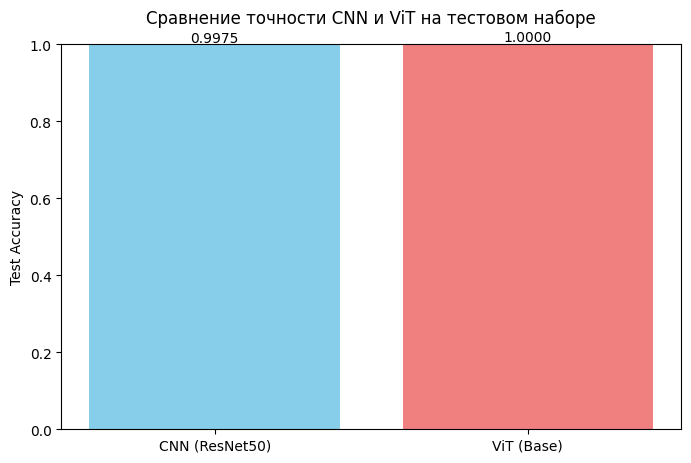

In [ ]:
logger.info("\n--- Сравнение моделей ---")
logger.info(f"CNN Model (ResNet50) Test Accuracy: {acc_test_cnn:.4f}")
logger.info(f"ViT Model (Base) Test Accuracy: {acc_test_vit:.4f}")

if acc_test_cnn > acc_test_vit:
    logger.info("\nМодель CNN (ResNet50) показала лучший результат на тестовом наборе.")
elif acc_test_vit > acc_test_cnn:
    logger.info("\nМодель ViT (Base) показала лучший результат на тестовом наборе.")
else:
    logger.info("\nМодели показали одинаковый результат на тестовом наборе.")

import matplotlib.pyplot as plt

models = ['CNN (ResNet50)', 'ViT (Base)']
accuracies = [acc_test_cnn, acc_test_vit]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral'])
plt.ylabel('Test Accuracy')
plt.title('Сравнение точности CNN и ViT на тестовом наборе', pad=15)
plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{acc:.4f}', ha='center', va='bottom')
plt.show()

### По итогу ввиду простоты датасета обе модели справились с задачей на ура. Так что, на простых задачах лучше использовать простые CNN модели благодаря их легкости по сравнению с ViT